In [249]:
import pandas as pd
import numpy as np
from datetime import datetime

In [250]:
%matplotlib inline

In [251]:
TRAIN = True

In [252]:
path = 'c:/data/mlbootcamp/dataset/'
path_train = path + 'train/'
path_test = path + 'test/'
path_features = 'features/'
if TRAIN:
    pathfiles = path_train
    path_subs_bs_consumption = 'subs_bs_consumption_train.csv'
    path_subs_bs_data_session = 'subs_bs_data_session_train.csv'
    path_subs_bs_voice_session = 'subs_bs_voice_session_train.csv'
    path_subs_features = 'subs_features_train.csv'
    path_subs_csi = 'subs_csi_train.csv'
    path_new_features = 'features.csv'
else:
    pathfiles = path_test
    path_subs_bs_consumption = 'subs_bs_consumption_test.csv'
    path_subs_bs_data_session = 'subs_bs_data_session_test.csv'
    path_subs_bs_voice_session = 'subs_bs_voice_session_test.csv'
    path_subs_features = 'subs_features_test.csv'
    path_subs_csi = 'subs_csi_test.csv'
    path_new_features = 'features.csv'

In [253]:
subs_csi = pd.read_csv(pathfiles + path_subs_csi, sep=';', decimal=',')

In [254]:
subs_csi.head(1)

,SK_ID,CSI,CONTACT_DATE
0,2,0,04.05


In [255]:
subs_csi.shape

(4222, 3)

In [256]:
subs_bs_consumption = pd.read_csv(pathfiles + path_subs_bs_consumption, sep=';', decimal=',')

In [257]:
subs_bs_consumption['month'] = subs_bs_consumption['MON'].apply(lambda x:int(str(x).split('.')[1]))

In [258]:
subs_bs_consumption.head(1)

,SK_ID,CELL_LAC_ID,MON,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN,month
0,1827,240277,01.03,0.0,0.000002,0.000234,3


In [259]:
subs_bs_consumption.shape

(1092544, 7)

In [15]:
users = subs_csi['SK_ID'].unique()
user_summary_sum_minutes = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}
user_summary_sum_data_mb = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}
user_summary_sum_data_min = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}

In [16]:
for i in subs_bs_consumption.values:
    user_summary_sum_minutes[(i[0], i[6])] += i[3]
    user_summary_sum_data_mb[(i[0], i[6])] += i[4]
    user_summary_sum_data_min[(i[0], i[6])] += i[5]

In [260]:
subs_bs_data_session = pd.read_csv(pathfiles + path_subs_bs_data_session, sep=';', decimal=',')

In [261]:
subs_bs_data_session.head(1)

,SK_ID,CELL_LAC_ID,DATA_VOL_MB,START_TIME
0,3853,61951,0.000004,04.04 05:00:00


In [262]:
subs_bs_data_session.shape

(3473203, 4)

In [263]:
subs_features = pd.read_csv(pathfiles + path_subs_features, sep=';', decimal=',')

In [264]:
subs_features.head(1)

,SNAP_DATE,COM_CAT#1,SK_ID,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,...,COM_CAT#25,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34
0,01.08.01,4,3339,80,5,2,1,12.0,1,1489.0,...,1,1,0.031696,0.076724,0.040279,0.0133,0.083382,0.027579,0.103896,2.0


In [265]:
subs_features.shape

(47411, 36)

In [266]:
subs_features['SNAP_DATE'] = subs_features['SNAP_DATE'].apply(lambda x:datetime.strptime(x, '%d.%m.%y'))

In [267]:
cats = subs_features['COM_CAT#24'].unique()
subs_features['COM_CAT#242'] = pd.Categorical(subs_features['COM_CAT#24'], categories=cats)
subs_features['COM_CAT#242'] = subs_features['COM_CAT#242'].cat.codes

In [268]:
subs_features['COM_CAT#34'].fillna(0, inplace=True)
subs_features['COM_CAT#8'].fillna(0, inplace=True)
subs_features['DEVICE_TYPE_ID'].fillna(0, inplace=True)
subs_features['ARPU_GROUP'].fillna(0, inplace=True)
subs_features['INTERNET_TYPE_ID'].fillna(0, inplace=True)

In [269]:
subs_features.dropna().shape

(47411, 37)

In [270]:
subs_features['month'] = subs_features['SNAP_DATE'].apply(lambda x:x.month)
subs_features['year'] = subs_features['SNAP_DATE'].apply(lambda x:x.year)

In [271]:
def get_subs_features(year, month, fix_month, day, sk_id):
    data = subs_features[(subs_features['year'] == year) & (subs_features['month'] == month) & (subs_features['SK_ID'] == sk_id)]
    columns = ['COM_CAT#1', 'COM_CAT#2', 'COM_CAT#3', 'BASE_TYPE', 'ACT', 'ARPU_GROUP', 'COM_CAT#7', 'COM_CAT#8',
              'DEVICE_TYPE_ID', 'INTERNET_TYPE_ID', 'REVENUE', 'ITC', 'VAS', 'RENT_CHANNEL', 'ROAM',
              'COST', 'COM_CAT#242']
    for i in range(18):
        if i + 17 == 24:
            if data.shape[0] == 1:
                d = data[['COM_CAT#24']].values[0].tolist()[0]
                dt = str(d).split('.')
                c_month = int(dt[1])
                c_day = int(dt[0])
                delta = (datetime(2002, fix_month, day) - datetime(2001 if d == '31.12' else 2002, c_month, c_day)).days
            continue
        columns.append('COM_CAT#{}'.format(i+17))
    if data.shape[0] == 1:
        return columns, data[columns].values[0].tolist()
    else:
        return columns, np.zeros(len(columns))

In [272]:
# for dnn
table = []
x = np.zeros(subs_csi.shape[0])
if TRAIN:
    y = np.zeros(subs_csi.shape[0])
for i in enumerate(subs_csi.values):
    sk_id = int(i[1][0])
    x[i[0]] = sk_id
    line = [sk_id]
    table_columns = ['sk_id']
    if TRAIN:
        dt = str(i[1][2]).split('.')
    else:
        dt = str(i[1][1]).split('.')
    year = 2002
    month = int(dt[1])
    for j in range(12):
        new_line = get_subs_features(year, month, int(dt[1]), int(dt[0]), sk_id)
        line.extend(new_line[1])
        table_columns.extend(new_line[0])
        month -= 1
        if month == 0:
            month = 12
            year -= 1
    #for j in range(3):
    #    line.append(user_summary_sum_minutes[(sk_id, int(dt[1]) - j)])
    #    line.append(user_summary_sum_data_mb[(sk_id, int(dt[1]) - j)])
    #    line.append(user_summary_sum_data_min[(sk_id, int(dt[1]) - j)])
    table.append(line)
    if TRAIN:
        y[i[0]] = i[1][1]

In [31]:
data = pd.DataFrame(data=table, columns=table_columns)

In [273]:
columns_avg = ['CELL_AVAILABILITY_2G', 'CELL_AVAILABILITY_3G',
       'CELL_AVAILABILITY_4G', 'CSSR_2G', 'CSSR_3G',
       'ERAB_PS_BLOCKING_RATE_LTE', 'ERAB_PS_BLOCKING_RATE_PLMN_LTE',
       'ERAB_PS_DROP_RATE_LTE', 'HSPDSCH_CODE_UTIL_3G',
       'NODEB_CNBAP_LOAD_HARDWARE', 'PART_CQI_QPSK_LTE', 'PART_MCS_QPSK_LTE',
       'PROC_LOAD_3G', 'PSSR_2G', 'PSSR_3G', 'PSSR_LTE',
       'RAB_CS_BLOCKING_RATE_3G', 'RAB_CS_DROP_RATE_3G',
       'RAB_PS_BLOCKING_RATE_3G', 'RAB_PS_DROP_RATE_3G', 'RBU_AVAIL_DL',
       'RBU_AVAIL_DL_LTE', 'RBU_AVAIL_UL', 'RBU_OTHER_DL', 'RBU_OTHER_UL',
       'RBU_OWN_DL', 'RBU_OWN_UL', 'RRC_BLOCKING_RATE_3G',
       'RRC_BLOCKING_RATE_LTE', 'RTWP_3G', 'SHO_FACTOR', 'TBF_DROP_RATE_2G',
       'TCH_DROP_RATE_2G', 'UTIL_BRD_CPU_3G', 'UTIL_CE_DL_3G',
       'UTIL_CE_HW_DL_3G', 'UTIL_CE_UL_3G', 'UTIL_SUBUNITS_3G',
       'UL_VOLUME_LTE', 'DL_VOLUME_LTE', 'TOTAL_DL_VOLUME_3G',
       'TOTAL_UL_VOLUME_3G']

In [274]:
columns_chhn = ['AVEUSERNUMBER', 'AVEUSERNUMBER_PLMN',
       'AVR_DL_HSPA_USER_3G', 'AVR_DL_R99_USER_3G', 'AVR_DL_USER_3G',
       'AVR_DL_USER_LTE', 'AVR_TX_POWER_3G', 'AVR_UL_HSPA_USER',
       'AVR_UL_R99_USER', 'AVR_UL_USER_3G', 'AVR_UL_USER_LTE',
       'DL_AVR_THROUGHPUT_3G', 'DL_AVR_THROUGHPUT_LTE',
       'DL_AVR_THROUGHPUT_R99', 'DL_MEAN_USER_THROUGHPUT_LTE',
       'DL_MEAN_USER_THROUGHPUT_DL_2G', 'DL_MEAN_USER_THROUGHPUT_HSPA3G',
       'DL_MEAN_USER_THROUGHPUT_PLTE', 'DL_MEAN_USER_THROUGHPUT_REL93G',
       'HSDPA_USERS_3G', 'HSUPA_USERS_3G', 'RBU_USED_DL', 'RBU_USED_UL',
       'RELATIVE_RBU_USED_DL', 'RELATIVE_RBU_USED_UL', 'RELATIVE_TX_POWER_3G',
       'UL_AVR_THROUGHPUT_3G', 'UL_AVR_THROUGHPUT_LTE',
       'UL_AVR_THROUGHPUT_R99', 'UL_MEAN_USER_THROUGHPUT_LTE',
       'UL_MEAN_USER_THROUGHPUT_HS3G', 'UL_MEAN_USER_THROUGHPUT_PLTE',
       'UL_MEAN_USER_THROUGHPUT_REL93G']

In [278]:
def get_extend_data(x, type_data, column_name):
    fname = pathfiles + path_features + '{}_{}.csv'.format(type_data, column_name)
    result = pd.read_csv(fname)
    result.fillna(0, inplace=True)
    table = []
    for i in zip(x, result.values):
        if i[0] != i[1][0]:
            raise exception()
        table.append(normalize([i[1][1:].reshape(result.shape[1]-1)]))
    return np.asarray(table)

def get_all_data():
    result = None
    for columns in [columns_avg, columns_chhn]:
        for c in columns:
            for type_data in ['data', 'voice']:
                t = get_extend_data(type_data, c)
                if result is None:
                    result = t
                else:
                    result = result.merge(t, how='inner', left_on='sk_id', right_on='sk_id')
    return result

In [279]:
data = get_extend_data(x, 'data', 'AVEUSERNUMBER')

In [280]:
data.shape

(4222, 1, 504)

In [30]:
data.head()

,sk_id,0 sum,0 count,0 min,0 avg,0 max,0 mina,0 avga,0 maxa,1 sum,...,61 avga,61 maxa,62 sum,62 count,62 min,62 avg,62 max,62 mina,62 avga,62 maxa
0,2,0.002705,2.0,0.043431,0.127861,0.178438,0.043431,0.127861,0.178438,0.000899,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0.000120,4.0,0.000000,0.001280,0.001298,0.000000,0.000000,0.000000,0.000407,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0.003875,8.0,0.003758,0.003758,0.003758,0.000000,0.000000,0.000000,0.031427,...,0.030815,0.048081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
res_data = data

In [65]:
from sklearn import preprocessing

In [247]:
X = np.asarray(res_data)
y = np.asarray(y)

In [213]:
X = np.array(X.tolist())

In [214]:
from sklearn.model_selection import train_test_split

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

In [217]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [218]:
from sklearn.metrics import roc_auc_score
from keras import regularizers
from sklearn.preprocessing import normalize

In [219]:
from sklearn import metrics
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [220]:
def create_cnn_model():
    #build Keras model
    
    sequence_input = Input(shape=X_test.shape[1:], dtype='float32')
    x = Conv1D(32, 1, activation='relu')(sequence_input)
    x = MaxPooling1D(1)(x)
    x = Conv1D(32, 1, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(16, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy', metrics=[auc], optimizer='adam')
    return model


In [241]:
count_epochs = 15
model = create_cnn_model()
#early_stopping_monitor = EarlyStopping(patience=20)
print(model.summary())
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 256, epochs = count_epochs, verbose=1, validation_split=0.2, class_weight=class_weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 1, 504)            0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 1, 32)             16160     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 1, 32)             0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 1, 32)             1056      
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 32)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 17        
Total para

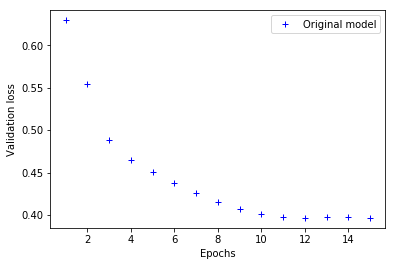

In [242]:
epochs = range(1, count_epochs + 1)
history_gr = history.history['val_loss']
import matplotlib.pyplot as plt

plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [243]:
predict = model.predict(np.array(X_test))
score = roc_auc_score(y_test, predict)
print("Total roc auc score = {0:0.4f}".format(score))

Total roc auc score = 0.5158
